In [111]:
import numpy as np
from scipy import stats 
import math
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from scipy.linalg import orth
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
dtype = torch.cuda.FloatTensor

Generate_data

In [112]:
def generate_data(R,n,d,big_sigma_squared,sigma_z,N):
    c=np.random.normal(loc=0, scale=1.0, size=[d,N])
    z=np.random.normal(loc=0, scale=sigma_z, size=[n,N])
    U=orth(np.random.normal(loc=0, scale=1, size=[n,n]))
    UT=U[:,d:]
    U=U[:,:d]
    L=np.random.choice([-1,1],N)
    L=L.reshape(L.shape[0],1)     
    if R==None:
        R=1

    mu=U @ (np.random.choice([-1,1],d).reshape(d,1))
    mu=R*(mu/np.linalg.norm(mu))
      
           
    U=U@big_sigma_squared
    X=U@c+mu@L.T 
    Y=X+z

    U = torch.from_numpy(U).type(dtype)
    X = torch.from_numpy(X).type(dtype)
    Y = torch.from_numpy(Y).type(dtype)
    L = torch.from_numpy(L).type(dtype)
    mu = torch.from_numpy(mu).type(dtype)
    
    return X,Y,U,L,mu

Compute the risk for a given estimator W subspace u and noise statistics sigma_z.

In [113]:
def test_risk_1(n,d,W,U,sigma_z,mu):    
    risk = torch.linalg.norm( (W - torch.eye(n).type(dtype)) @ U ,'fro')**2 + sigma_z**2 * torch.linalg.norm(W,'fro')**2+ torch.linalg.norm( (W- torch.eye(n).type(dtype)) @ mu )**2
    # 
    return risk/d

In [114]:
def test_risk_2 (mu,W1,W2,U,sigma_z):    
    a = (torch.norm(W2@W1@U)**2+torch.norm(sigma_z*(W2@W1)**2)).item()
    a=np.sqrt(a)    
    b = (W2@W1@mu).item()
    risk=0.5*(1-stats.norm.cdf(b,loc=0,scale=a)) + 0.5*(stats.norm.cdf(-b,loc=0,scale=a))
    return risk

Estimator learned end-to-end $W^k$

In [115]:
def gradient_descent_1(W1,W2,X,Y,L,alpha1,lr):
    if alpha1==None:
        a=(W1 @ Y @ Y.T - X @ Y.T)
        b=(W2.T @ (L.T * (sigmoid(L.T*(W2@W1@Y))-1))  @ Y.T)
        A=torch.trace(a@a.T+b@b.T-a@b.T-b@a.T)
        B=torch.trace(a@b.T+b@a.T-2*b@b.T)        
        alpha1=torch.max(torch.tensor([torch.min(torch.tensor([-B/(2*A),1])),0]))
        
        dW = (1-alpha1)*(W1 @ Y @ Y.T - X @ Y.T)
        dW+= alpha1*(W2.T @ (L.T * (sigmoid(L.T*(W2@W1@Y))-1))  @ Y.T)
        W1 -= lr*dW
        return W1
    else:
        dW = (1-alpha1)*(W1 @ Y @ Y.T - X @ Y.T)
        dW+= alpha1*(W2.T @ (L.T * (sigmoid(L.T*(W2@W1@Y))-1))  @ Y.T)
        W1 -= lr*dW
        return W1

def gradient_descent_2(W1,W2,X,Y,L,alpha1,lr):
    if alpha1==None:
        alpha1=1
    dW = alpha1*L.T * ( sigmoid(L.T* (W2@W1@Y)) -1 ) @ (W1@Y).T
    W2 -= lr*dW
    return W2



def sigmoid(X):    
    return 1/(1+torch.exp(-X))



def gradient_descent_train(mu,n,d,N,X, Y, U ,L , sigma_z, num_iters=1000, lr = 1e-2, alpha1=None):
        trainL_emp_1 = []
        trainL_emp_2 = []
        testL1 = []
        testL2 = []
        testL3 = []
        testL4 = []
        testL5 = []        
        early_stopping_counter = 0
        early_stopping_loss = 10000
        W1 = torch.zeros([n,n]).type(dtype)
        W3 = torch.zeros([n,n]).type(dtype)
        W2 = torch.zeros([1,n]).type(dtype)
        W4 = torch.zeros([1,n]).type(dtype)
        for i in range(num_iters):
            if i % 100 == 0:
                print('Iteration : {}/{}'.format(i,num_iters))
            ### train
            # compute the gradient and update the weights
            W1 = gradient_descent_1(W1,W2,X,Y,L,alpha1,lr)
            W2 = gradient_descent_2(W1,W2,X,Y,L,alpha1,lr)
            W3 = gradient_descent_1(W3,torch.eye(n).type(dtype),X,Y,L,0,lr)
            W4 = gradient_descent_2(torch.eye(n).type(dtype),W4,X,Y,L,alpha1,lr)           
            lr=0.999*lr
            # train loss
            Xhat = W1 @ Y            
            trl1 =  (( (Xhat-X)**2 ).sum()/(N*d))
            trl2 =  torch.log(1+torch.exp(-L.T* (W2@W1@Y) )) .sum()/(N)
            trainL_emp_1.append(trl1.item())
            trainL_emp_2.append(trl2.item())

            ### test
            #denoise           
            tel1 =  test_risk_1(n,d,W1,U,sigma_z,mu)
            testL1.append(tel1.item())
            #classifer
            tel2 =  test_risk_2(mu,W1,W2,U,sigma_z)
            testL2.append(tel2.item())
            #sum
            tel3 =  tel1+tel2
            testL3.append(tel3.item())
            #only denoise
            tel3 = test_risk_1(n,d,W3,U,sigma_z,mu)
            testL4.append(tel3.item())
            #only classifer
            tel3 = test_risk_2(mu,torch.eye(n).type(dtype),W4,U,sigma_z)
            testL5.append(tel3.item())
           
            
            # Stop if train loss is not improving anymore
            if i>100 and np.abs(trainL_emp_1[-1]-trainL_emp_1[-2])+np.abs(trainL_emp_2[-1]-trainL_emp_2[-2]) < 1e-10:
                print('Stopped at iteration {} due to convergence'.format(i))
                break
            
            
            # Early stopp 100 iterations after the test loss reached its minimum
            if testL1[-1]+testL2[-1] < early_stopping_loss:
                early_stopping_loss = testL1[-1]+testL2[-1]
            else:
                early_stopping_counter += 1
            if early_stopping_counter == 500:
                print('Stopped at iteration {} due to early stopping'.format(i))
                break
              
        return testL1, testL2, testL3, testL4, testL5, trainL_emp_1, trainL_emp_2

Numerical experiment

In [116]:
n=1000
d=500
R=5
alpha1=None
big_sigma_squared=np.eye(d)
sigma_z=0.05
train_size = [2,4,8,10,12,14,16,18,22,24,30,36,44,64,100,256,512,1024]#,2048]#,4096]#,8192,16384]
runs=2
precision = 8

$ lr = \frac{1}{ (N *(1+\sqrt{10* (d+\sigma_z^2*n) * \log(n) / N}   ) * (1+\sigma_z^2))}$

Denoise and classifer

**********run 0**********
*****training size (N) = 2*****


Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Iteration : 700/1000
Iteration : 800/1000
Iteration : 900/1000


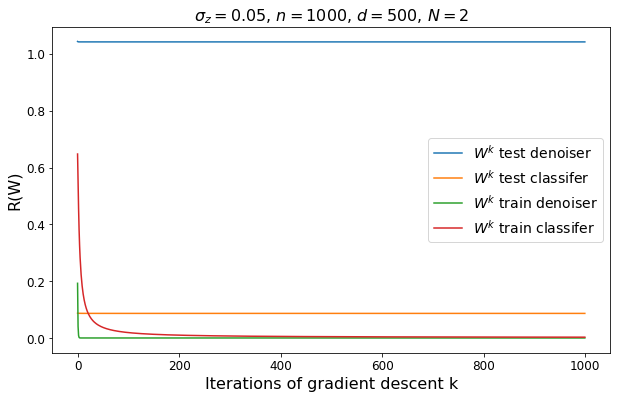



*****training size (N) = 4*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 503 due to early stopping


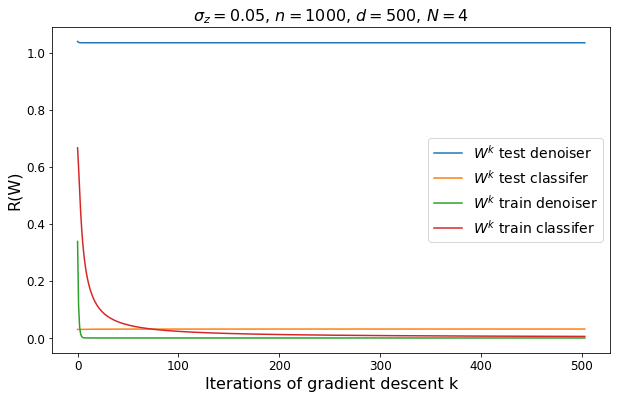



*****training size (N) = 8*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 507 due to early stopping


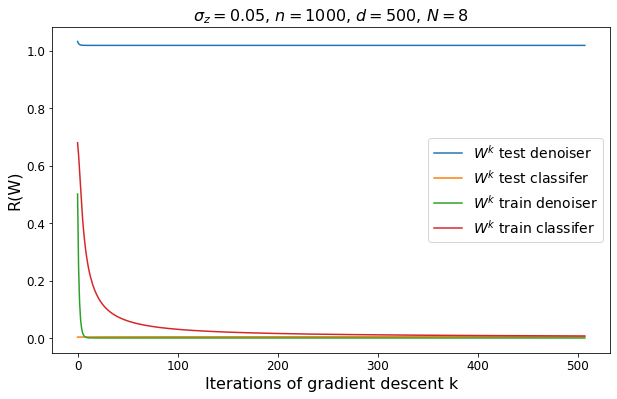



*****training size (N) = 10*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 529 due to early stopping


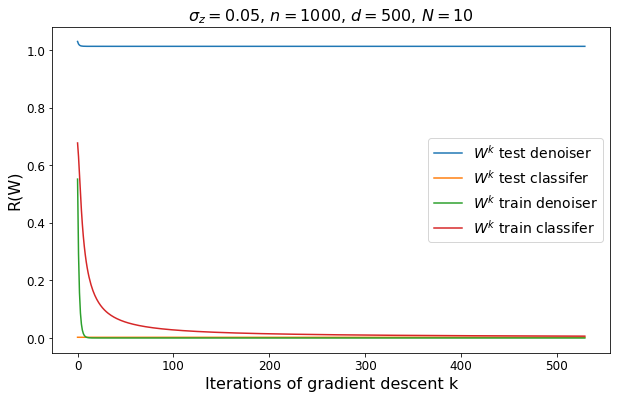



*****training size (N) = 12*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 518 due to early stopping


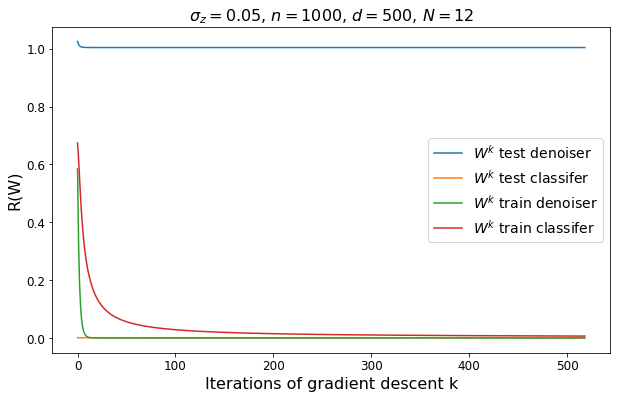



*****training size (N) = 14*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 530 due to early stopping


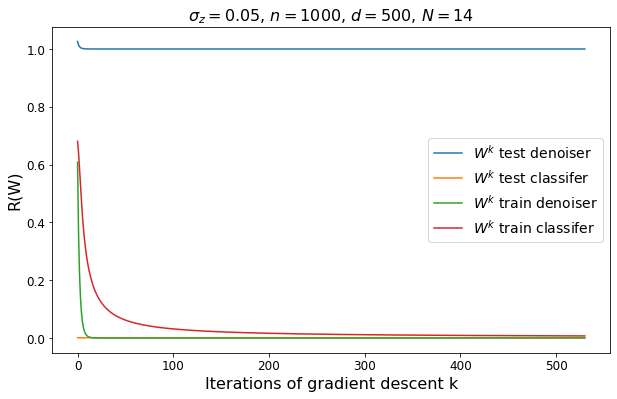



*****training size (N) = 16*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 534 due to early stopping


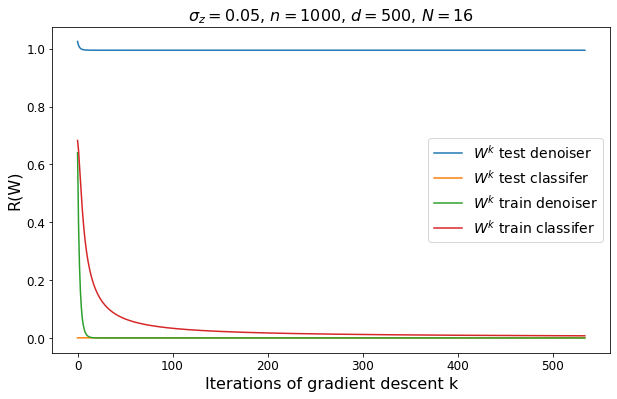



*****training size (N) = 18*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 533 due to early stopping


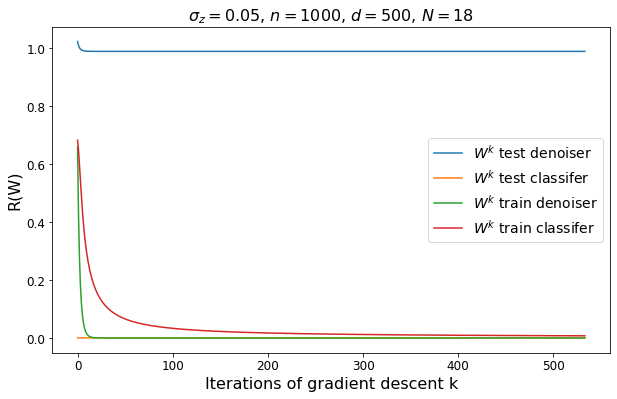



*****training size (N) = 22*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 542 due to early stopping


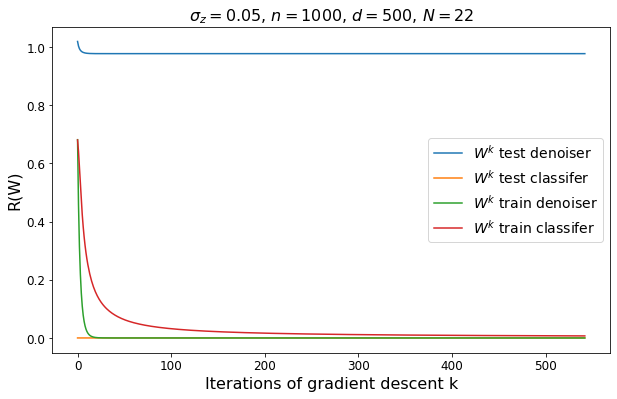



*****training size (N) = 24*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 536 due to early stopping


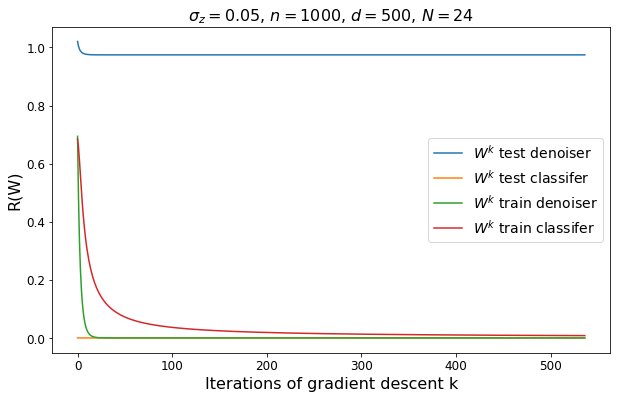



*****training size (N) = 30*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 560 due to early stopping


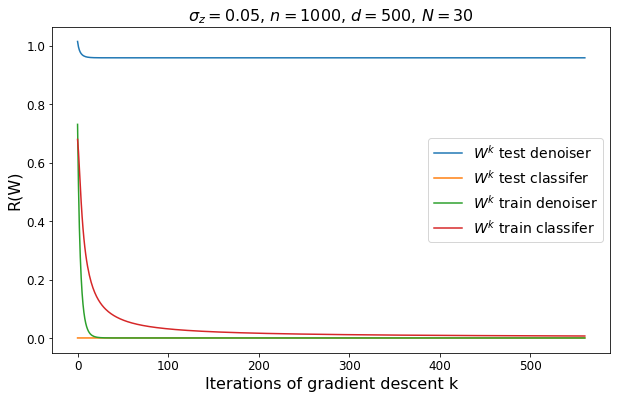



*****training size (N) = 36*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 571 due to early stopping


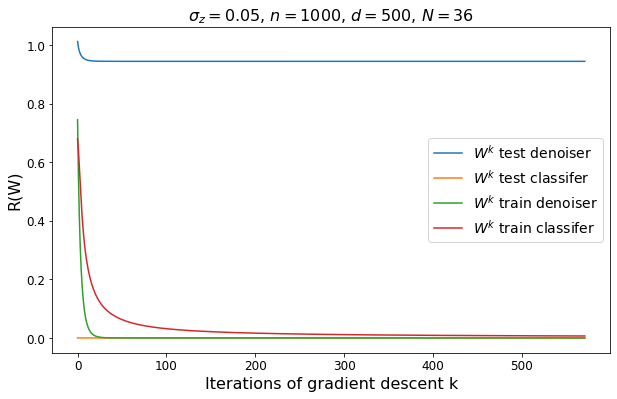



*****training size (N) = 44*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 584 due to early stopping


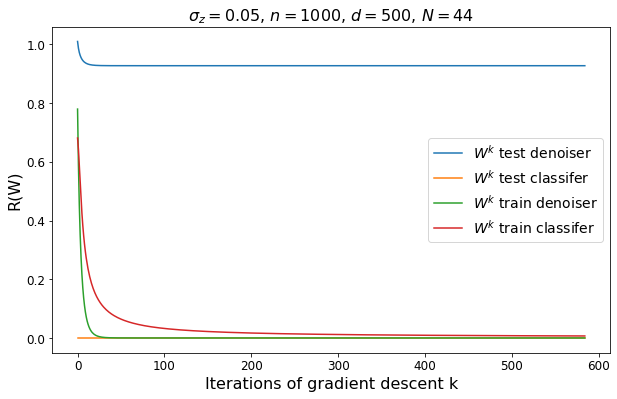



*****training size (N) = 64*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Stopped at iteration 631 due to early stopping


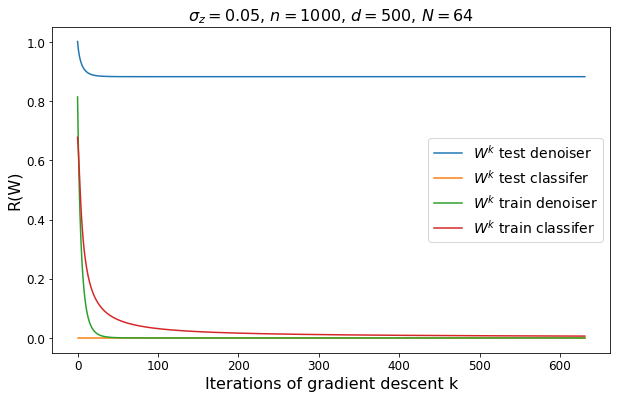



*****training size (N) = 100*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Iteration : 700/1000
Stopped at iteration 727 due to early stopping


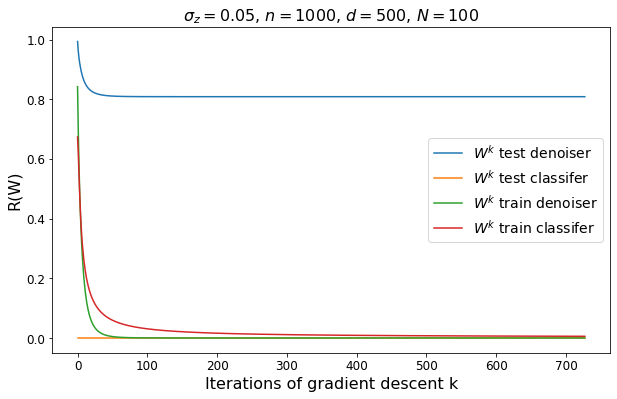



*****training size (N) = 256*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Iteration : 700/1000
Iteration : 800/1000
Iteration : 900/1000


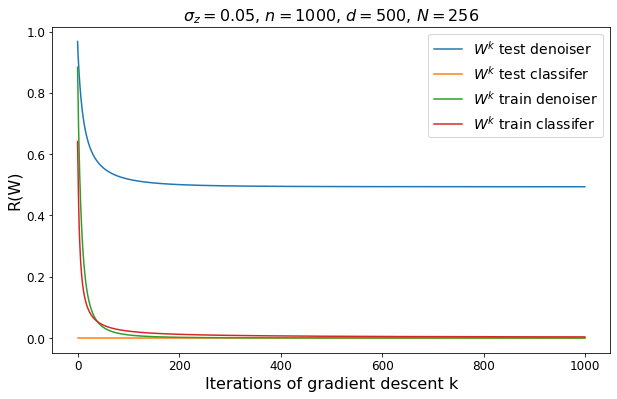



*****training size (N) = 512*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Iteration : 700/1000
Iteration : 800/1000
Iteration : 900/1000


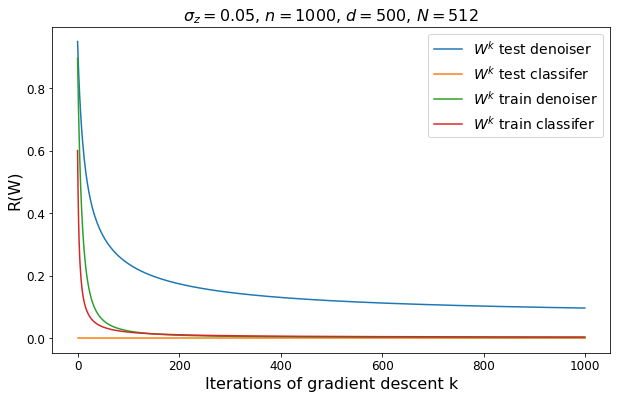



*****training size (N) = 1024*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Iteration : 600/1000
Iteration : 700/1000
Iteration : 800/1000
Iteration : 900/1000


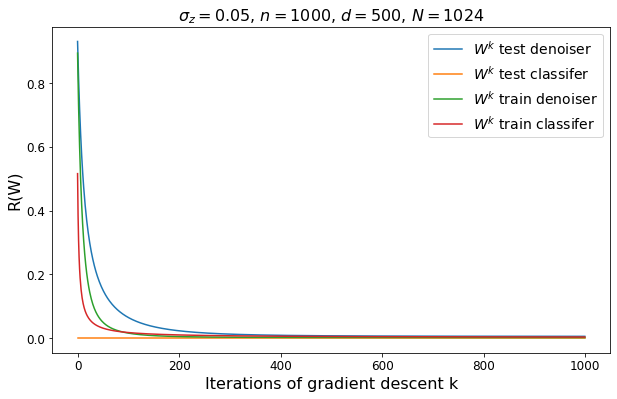



**********run 1**********
*****training size (N) = 2*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 501 due to early stopping


*****training size (N) = 4*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 508 due to early stopping


*****training size (N) = 8*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 517 due to early stopping


*****training size (N) = 10*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500/1000
Stopped at iteration 515 due to early stopping


*****training size (N) = 12*****
Iteration : 0/1000
Iteration : 100/1000
Iteration : 200/1000
Iteration : 300/1000
Iteration : 400/1000
Iteration : 500

In [117]:
# Store results
learn_results = {'test_l':{},'test_l2':{},'test_l3':{},'test_l4':{},'test_l5':{},'opt':np.zeros([runs,len(train_size)]),'train_l_emp_1':{}, 'train_l_emp_2':{}}
opt=np.zeros([runs,len(train_size)])

for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        print("*****training size (N) = {}*****".format(N))
        X,Y,U,L,mu = generate_data(R,n,d,big_sigma_squared,sigma_z,N)
        
        W=X@torch.pinverse(Y)
        learn_results['opt'][r,i] = test_risk_1(n,d,W,U,sigma_z,mu)
        #alpha1=1/N
        #+torch.diag(mu.T[0])@torch.diag(mu.T[0])
        #         
        W=((d+R**2)/(d+R**2+d*sigma_z**2))*U@U.T
        tel=test_risk_1(n,d,W,U,sigma_z,mu).item()
        tel=tel/d
        opt[r,i]= tel
        
        ### Estimator learned with gradient descent
        #num_iters = 5000
        epsilon = np.sqrt( (d+sigma_z**2*n) * np.log(n) / N)
        #print(epsilon)
        lr = 1/((10*N* (1+epsilon) * (1+sigma_z**2)))
        
        
        testL1, testL2, testL3, testL4, testL5, trainL_emp_1, trainL_emp_2 = gradient_descent_train(mu,n,d,N,X, Y, U ,L , sigma_z, num_iters=1000, lr = lr, alpha1=alpha1)
        learn_results['test_l'][str(r)+str(i)] = testL1
        learn_results['test_l2'][str(r)+str(i)] = testL2
        learn_results['test_l3'][str(r)+str(i)] = testL3
        learn_results['test_l4'][str(r)+str(i)] = testL4
        learn_results['test_l5'][str(r)+str(i)] = testL5
        learn_results['train_l_emp_1'][str(r)+str(i)] = trainL_emp_1
        learn_results['train_l_emp_2'][str(r)+str(i)] = trainL_emp_2
        #risk_last = np.round(learn_results['test_l2'][str(r)+str(i)][-1],precision)
        #risk_early_stopped = np.round(np.min(learn_results['test_l2'][str(r)+str(i)]),precision)
        #train_loss = learn_results['train_l_emp_2'][str(r)+str(i)][-1]
        #print("Gradient descent: test risk last: {}; test risk early stopped: {}; train loss: {}".format(risk_last,risk_early_stopped,train_loss))           



        if r==0:
            fontsize = 16
            fig = plt.figure(figsize=(10,6))
            
            ax = fig.add_subplot(111)
            steps = len(learn_results['test_l'][str(r)+str(i)])
            #ax.plot(range(steps), learn_results['train_l_emp'][str(r)+str(i)],label=r"$W^{k}$ train")
            ax.plot(range(steps), learn_results['test_l'][str(r)+str(i)], label=r"$W^{k}$ test denoiser")
            ax.plot(range(steps), learn_results['test_l2'][str(r)+str(i)], label=r"$W^{k}$ test classifer")
            #ax.plot(range(steps), learn_results['test_l3'][str(r)+str(i)], label=r"$W^{k}$ test sum")
            ax.plot(range(steps), learn_results['train_l_emp_1'][str(r)+str(i)], label=r"$W^{k}$ train denoiser")
            ax.plot(range(steps), learn_results['train_l_emp_2'][str(r)+str(i)], label=r"$W^{k}$ train classifer")

            #ax.set_yscale('log')
            ax.set_title('$\sigma_z=${}, $n=${}, $d=${}, $N=${}'.format(sigma_z,n,d,N), fontsize=fontsize)
            ax.tick_params(axis='x', labelsize=fontsize-4 ) 
            ax.tick_params(axis='y', labelsize=fontsize-4 ) 
            ax.set_xlabel('Iterations of gradient descent k', fontsize=fontsize)
            ax.set_ylabel('R(W)', fontsize=fontsize)
            ax.legend(fontsize=fontsize-2)
            plt.show()

        print("\n")

In [118]:
'''
for r in range(runs):
    print("**********run {}**********".format(r))
    for i,N in enumerate(train_size):
        fontsize = 16
        fig = plt.figure(figsize=(10,6))
        
        ax = fig.add_subplot(111)
        steps = len(learn_results['test_l'][str(r)+str(i)])
        #ax.plot(range(steps), learn_results['train_l_emp'][str(r)+str(i)],label=r"$W^{k}$ train")
        ax.plot(range(steps), learn_results['test_l'][str(r)+str(i)], label=r"$W^{k}$ test denoiser")
        #ax.plot(range(steps), learn_results['test_l2'][str(r)+str(i)], label=r"$W^{k}$ test classifer")
        #ax.plot(range(steps), learn_results['test_l3'][str(r)+str(i)], label=r"$W^{k}$ test sum")
        #ax.plot(range(steps), learn_results['train_l_emp_1'][str(r)+str(i)], label=r"$W^{k}$ train denoiser")
        #ax.plot(range(steps), learn_results['train_l_emp_2'][str(r)+str(i)], label=r"$W^{k}$ train classifer")

        #ax.set_yscale('log')
        ax.set_title('$\sigma_z=${}, $n=${}, $d=${}, $N=${}'.format(sigma_z,n,d,N), fontsize=fontsize)
        ax.tick_params(axis='x', labelsize=fontsize-4 ) 
        ax.tick_params(axis='y', labelsize=fontsize-4 ) 
        ax.set_xlabel('Iterations of gradient descent k', fontsize=fontsize)
        ax.set_ylabel('R(W)', fontsize=fontsize)
        ax.legend(fontsize=fontsize-2)
        plt.show()
'''


'\nfor r in range(runs):\n    print("**********run {}**********".format(r))\n    for i,N in enumerate(train_size):\n        fontsize = 16\n        fig = plt.figure(figsize=(10,6))\n        \n        ax = fig.add_subplot(111)\n        steps = len(learn_results[\'test_l\'][str(r)+str(i)])\n        #ax.plot(range(steps), learn_results[\'train_l_emp\'][str(r)+str(i)],label=r"$W^{k}$ train")\n        ax.plot(range(steps), learn_results[\'test_l\'][str(r)+str(i)], label=r"$W^{k}$ test denoiser")\n        #ax.plot(range(steps), learn_results[\'test_l2\'][str(r)+str(i)], label=r"$W^{k}$ test classifer")\n        #ax.plot(range(steps), learn_results[\'test_l3\'][str(r)+str(i)], label=r"$W^{k}$ test sum")\n        #ax.plot(range(steps), learn_results[\'train_l_emp_1\'][str(r)+str(i)], label=r"$W^{k}$ train denoiser")\n        #ax.plot(range(steps), learn_results[\'train_l_emp_2\'][str(r)+str(i)], label=r"$W^{k}$ train classifer")\n\n        #ax.set_yscale(\'log\')\n        ax.set_title(\'$\\sigm

In [119]:
#######
# Compute mean and std for plot
#######
# test performance of early stopped gradient descent
learn_results_ES = {'test_l':np.zeros([runs,len(train_size)])}
for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l'][str(r)+str(i)])
learn_results_ES_denoiser_M = learn_results_ES['test_l'].mean(0)
learn_results_ES_denoiser_S = learn_results_ES['test_l'].std(0)
for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l2'][str(r)+str(i)])
learn_results_ES_classifer_M = learn_results_ES['test_l'].mean(0)
learn_results_ES_classifer_S = learn_results_ES['test_l'].std(0)
for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l4'][str(r)+str(i)])
denoiser_M = learn_results_ES['test_l'].mean(0)
denoiser_S = learn_results_ES['test_l'].std(0)

for r in range(runs):
    for i in range(len(train_size)):
        learn_results_ES['test_l'][r,i] = np.min(learn_results['test_l5'][str(r)+str(i)])
classifer_M = learn_results_ES['test_l'].mean(0)
classifer_S = learn_results_ES['test_l'].std(0)


In [120]:
learn_results_ES_denoiser_M

array([1.04029876, 1.03301316, 1.02095574, 1.01233798, 1.00627232,
       1.00084352, 0.99576554, 0.98941267, 0.97869354, 0.97471842,
       0.95823863, 0.94531614, 0.92686668, 0.88318205, 0.80762535,
       0.49375901, 0.09552741, 0.00509783])

In [121]:
denoiser_M

array([1.04029882, 1.03301322, 1.0209558 , 1.01233852, 1.00627249,
       1.00084382, 0.99576619, 0.98941284, 0.97869366, 0.97471836,
       0.95823908, 0.94531634, 0.92686665, 0.8831822 , 0.80762538,
       0.49374186, 0.09532004, 0.0050705 ])

In [122]:
learn_results['opt'].mean(0)

array([1.04029888, 1.03301328, 1.02095592, 1.01233864, 1.00627261,
       1.00084388, 0.99576628, 0.98941293, 0.97869387, 0.97471842,
       0.95823917, 0.9453164 , 0.92686674, 0.88318235, 0.80762547,
       0.49367468, 0.04358164, 0.10863295])

In [123]:
learn_results_ES_classifer_M

array([5.58860453e-02, 1.96557361e-02, 6.74615563e-03, 1.77581096e-03,
       1.15976316e-03, 6.71763550e-04, 5.41654962e-04, 2.70691048e-04,
       1.38670261e-04, 1.54896062e-04, 4.73447321e-05, 3.44807166e-05,
       1.80538478e-05, 7.17250285e-06, 2.56109495e-06, 7.56507431e-07,
       4.80248845e-07, 3.85374529e-07])

In [124]:
classifer_M

array([5.65531738e-02, 1.98528535e-02, 7.01794518e-03, 1.77770796e-03,
       1.18441730e-03, 6.74334733e-04, 5.43850239e-04, 2.71773504e-04,
       1.38579810e-04, 1.57534194e-04, 4.71278108e-05, 3.49231357e-05,
       1.79708738e-05, 7.14496406e-06, 2.54080004e-06, 7.51943398e-07,
       4.76256860e-07, 3.82729848e-07])

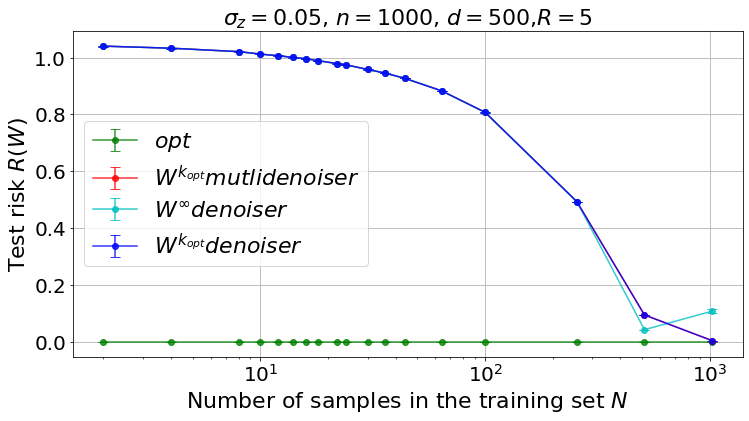

In [125]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
ax.errorbar(train_size, opt.mean(0), yerr=opt.std(0), color='g', fmt="-o",alpha=al,label=r"$opt$", capsize=5)
ax.errorbar(train_size, learn_results_ES_denoiser_M, yerr=learn_results_ES_denoiser_S, color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}} mutli denoiser$", capsize=5)
ax.errorbar(train_size, learn_results['opt'].mean(0), yerr=learn_results['opt'].std(0), color='c', fmt="-o",alpha=al,label=r"$W^{\infty} denoiser$", capsize=5)
#ax.errorbar(train_size, learn_results_ES_classifer_M, yerr=learn_results_ES_classifer_S, color='g', fmt="-o",alpha=al,label=r"$W^{k_{opt}} classifer$", capsize=5)
ax.errorbar(train_size, denoiser_M, yerr=denoiser_S, color='b', fmt="-o",alpha=al,label=r"$W^{k_{opt}} denoiser$", capsize=5)

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${},$R=${}'.format(sigma_z,n,d,R), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0,1])

plt.grid()
plt.show()

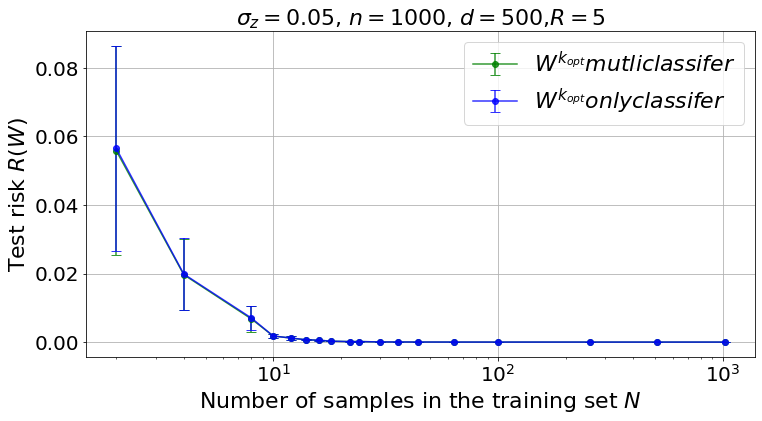

In [126]:
fontsize = 22

fig = plt.figure(figsize=(12,6))
al=0.8
ax = fig.add_subplot(111)
#ax.errorbar(train_size, opt.mean(0), yerr=opt.std(0), color='g', fmt="-o",alpha=al,label=r"$opt$", capsize=5)
#ax.errorbar(train_size, learn_results_ES_denoiser_M, yerr=learn_results_ES_denoiser_S, color='r', fmt="-o",alpha=al,label=r"$W^{k_{opt}} denoiser$", capsize=5)
#ax.errorbar(train_size, learn_results['opt'].mean(0), yerr=learn_results['opt'].std(0), color='c', fmt="-o",alpha=al,label=r"$W^{\infty} denoiser$", capsize=5)
ax.errorbar(train_size, learn_results_ES_classifer_M, yerr=learn_results_ES_classifer_S, color='g', fmt="-o",alpha=al,label=r"$W^{k_{opt}} mutli classifer$", capsize=5)
ax.errorbar(train_size, classifer_M, yerr=classifer_S, color='b', fmt="-o",alpha=al,label=r"$W^{k_{opt}} only classifer$", capsize=5)

ax.set_xlabel("Number of samples in the training set $N$", fontsize=fontsize)
ax.set_ylabel(r"Test risk $R(W)$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
ax.set_title('$\sigma_z=${}, $n=${}, $d=${},$R=${}'.format(sigma_z,n,d,R), fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-2 ) 
ax.tick_params(axis='y', labelsize=fontsize-2 ) 
base =10
#ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([0,0.5])

plt.grid()
plt.show()